This is an implementation of the paper Deep Bayesian Active Learning with Image Data using PyTorch and modAL. 

modAL is an active learning framework for Python3, designed with modularity, flexibility and extensibility in mind. Built on top of scikit-learn, it allows you to rapidly create active learning workflows with nearly complete freedom. What is more, you can easily replace parts with your custom built solutions, allowing you to design novel algorithms with ease.

Since modAL only supports sklearn models, we will also use [skorch](https://skorch.readthedocs.io/en/stable/), a scikit-learn compatible neural network library that wraps PyTorch. 

In [1]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from skorch import NeuralNetClassifier
from modAL.models import ActiveLearner

from VAE import VAE

C:\Users\saumy\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


### architecture of the network we will be using

We will use the architecture described in the paper.

In [2]:
class CNN(nn.Module):
    def __init__(self,):
        super(CNN, self).__init__()
        self.convs = nn.Sequential(
                                nn.Conv2d(1,32,4),
                                nn.ReLU(),
                                nn.Conv2d(32,32,4),
                                nn.ReLU(),
                                nn.MaxPool2d(2),
                                nn.Dropout(0.25)
        )
        self.fcs = nn.Sequential(
                                nn.Linear(11*11*32,128),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(128,10),
        )

    def forward(self, x):
        out = x
        out = self.convs(out)
        out = out.view(-1,11*11*32)
        out = self.fcs(out)
        return out

### read training data

In [3]:
mnist_train = MNIST('.', train=True, download=True, transform=ToTensor())
mnist_test  = MNIST('.', train=False,download=True, transform=ToTensor())
traindataloader = DataLoader(mnist_train, shuffle=True, batch_size=60000)
testdataloader  = DataLoader(mnist_test , shuffle=True, batch_size=10000)
X_train, y_train = next(iter(traindataloader))
X_test , y_test  = next(iter(testdataloader))
X_train, y_train = X_train.detach().cpu().numpy(), y_train.detach().cpu().numpy()
X_test, y_test = X_test.detach().cpu().numpy(), y_test.detach().cpu().numpy()

### preprocessing

In [4]:
X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28, 28)

### initial labelled data
We initialize the labelled set with 20 balanced randomly sampled examples

In [5]:
initial_idx = np.array([],dtype=int)
for i in range(10):
    idx = np.random.choice(np.where(y_train==i)[0], size=2, replace=False)
    initial_idx = np.concatenate((initial_idx, idx))

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

### initial unlabelled pool

In [6]:
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

## Query Strategies

### Uniform
All the acquisition function we will use will be compared to the uniform acquisition function $\mathbb{U}_{[0,1]}$ which will be our baseline that we would like to beat.

In [7]:
def uniform(learner, X, n_instances=1):
    query_idx = np.random.choice(range(len(X)), size=n_instances, replace=False)
    return query_idx, X[query_idx]

### Entropy
Our first acquisition function is the entropy:
$$ \mathbb{H} = - \sum_{c} p_c \log(p_c)$$
where $p_c$ is the probability predicted for class c. This is approximated by:
\begin{align}
p_c &= \frac{1}{T} \sum_t p_{c}^{(t)} 
\end{align}
where $p_{c}^{t}$ is the probability predicted for class c at the t th feedforward pass.

In [8]:
def max_entropy(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=2000, replace=False)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training=True),dim=-1).cpu().numpy()
                            for t in range(100)])
    pc = outputs.mean(axis=0)
    acquisition = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]

In [9]:
def bald(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=2000, replace=False)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training=True),dim=-1).cpu().numpy()
                            for t in range(100)])
    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0)  # [batch size]
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]    

In [10]:
def save_list(input_list, name):
    with open("perf_lists/" + name, 'w') as f:
        for val in input_list:
            f.write("%s\n" % val)

### Active Learning Procedure

In [10]:
def active_learning_procedure(query_strategy,
                              X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              estimator,
                              n_queries=100,
                              n_instances=10):
    learner = ActiveLearner(estimator=estimator,
                            X_training=X_initial,
                            y_training=y_initial,
                            query_strategy=query_strategy,
                           )
    perf_hist = [learner.score(X_test, y_test)]
    for index in range(n_queries):
        query_idx, query_instance = learner.query(X_pool, n_instances)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy = learner.score(X_test, y_test)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
        perf_hist.append(model_accuracy)
    return perf_hist

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
uniform_perf_hist = active_learning_procedure(uniform,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)
save_list(uniform_perf_hist, "uniform_perf_hist")

Accuracy after query 1: 0.6217
Accuracy after query 2: 0.6865
Accuracy after query 3: 0.6913
Accuracy after query 4: 0.7282
Accuracy after query 5: 0.7600
Accuracy after query 6: 0.7783
Accuracy after query 7: 0.7833
Accuracy after query 8: 0.8484
Accuracy after query 9: 0.8280
Accuracy after query 10: 0.8372
Accuracy after query 11: 0.8029
Accuracy after query 12: 0.8270
Accuracy after query 13: 0.8216
Accuracy after query 14: 0.8448
Accuracy after query 15: 0.8421
Accuracy after query 16: 0.8574
Accuracy after query 17: 0.8526
Accuracy after query 18: 0.8594
Accuracy after query 19: 0.8754
Accuracy after query 20: 0.8691
Accuracy after query 21: 0.8715
Accuracy after query 22: 0.8781
Accuracy after query 23: 0.8866
Accuracy after query 24: 0.8928
Accuracy after query 25: 0.8966
Accuracy after query 26: 0.9011
Accuracy after query 27: 0.8901
Accuracy after query 28: 0.9014
Accuracy after query 29: 0.8934
Accuracy after query 30: 0.8921
Accuracy after query 31: 0.8932
Accuracy after qu

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
bald_perf_hist = active_learning_procedure(bald,
                                           X_test,
                                           y_test,
                                           X_pool,
                                           y_pool,
                                           X_initial,
                                           y_initial,
                                           estimator,)
save_list(bald_perf_hist, "bald_perf_hist")

Accuracy after query 1: 0.6252
Accuracy after query 2: 0.6763
Accuracy after query 3: 0.6834
Accuracy after query 4: 0.7401
Accuracy after query 5: 0.7475
Accuracy after query 6: 0.7528
Accuracy after query 7: 0.7667
Accuracy after query 8: 0.7750
Accuracy after query 9: 0.7693
Accuracy after query 10: 0.6720
Accuracy after query 11: 0.6964
Accuracy after query 12: 0.7847
Accuracy after query 13: 0.7626
Accuracy after query 14: 0.8034
Accuracy after query 15: 0.8194
Accuracy after query 16: 0.8333
Accuracy after query 17: 0.8060
Accuracy after query 18: 0.8617
Accuracy after query 19: 0.8135
Accuracy after query 20: 0.8414
Accuracy after query 21: 0.8129
Accuracy after query 22: 0.8446
Accuracy after query 23: 0.8833
Accuracy after query 24: 0.8961
Accuracy after query 25: 0.8973
Accuracy after query 26: 0.9246
Accuracy after query 27: 0.9300
Accuracy after query 28: 0.9402
Accuracy after query 29: 0.9364
Accuracy after query 30: 0.9391
Accuracy after query 31: 0.9339
Accuracy after qu

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
entropy_perf_hist = active_learning_procedure(max_entropy,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)
save_list(entropy_perf_hist, "entropy_perf_hist")

Accuracy after query 1: 0.5734
Accuracy after query 2: 0.5829
Accuracy after query 3: 0.6805
Accuracy after query 4: 0.7403
Accuracy after query 5: 0.7608
Accuracy after query 6: 0.7645
Accuracy after query 7: 0.7776
Accuracy after query 8: 0.7933
Accuracy after query 9: 0.8150
Accuracy after query 10: 0.8080
Accuracy after query 11: 0.8201
Accuracy after query 12: 0.8162
Accuracy after query 13: 0.8646
Accuracy after query 14: 0.8302
Accuracy after query 15: 0.8514
Accuracy after query 16: 0.8617
Accuracy after query 17: 0.8759
Accuracy after query 18: 0.8785
Accuracy after query 19: 0.8857
Accuracy after query 20: 0.8997
Accuracy after query 21: 0.8865
Accuracy after query 22: 0.9159
Accuracy after query 23: 0.9063
Accuracy after query 24: 0.8940
Accuracy after query 25: 0.8869
Accuracy after query 26: 0.9111
Accuracy after query 27: 0.9215
Accuracy after query 28: 0.9168
Accuracy after query 29: 0.9302
Accuracy after query 30: 0.9357
Accuracy after query 31: 0.9357
Accuracy after qu

In [12]:
def active_learning_procedure_generative(query_strategy,
                              X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              estimator,
                              n_queries=100,
                              n_instances=10):
    weights_location = 'weights.pt'
    vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
    vae.load_state_dict(torch.load(weights_location))

    def vaeNewSampleGenerator(vae, samples):    
        vae.eval()
        with torch.no_grad():
            new_samples, _, _ = vae(samples.reshape(samples.shape[0], -1))
            return new_samples.reshape(samples.shape)

    learner = ActiveLearner(estimator=estimator,
                            X_training=X_initial,
                            y_training=y_initial,
                            query_strategy=query_strategy,
                           )
    perf_hist = [learner.score(X_test, y_test)]
    for index in range(n_queries):
        query_idx, query_instance = learner.query(X_pool, n_instances)
        
        new_samples = vaeNewSampleGenerator(vae, torch.tensor(X_pool[query_idx]))
        new_samples = new_samples.detach().cpu().numpy()
        new_samples = np.concatenate((new_samples, X_pool[query_idx]))
        new_labels = np.concatenate((y_pool[query_idx], y_pool[query_idx]))
        learner.teach(new_samples, new_labels)
        
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy = learner.score(X_test, y_test)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
        perf_hist.append(model_accuracy)
    return perf_hist

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
bald_generative_perf_hist = active_learning_procedure_generative(bald,
                                           X_test,
                                           y_test,
                                           X_pool,
                                           y_pool,
                                           X_initial,
                                           y_initial,
                                           estimator,)
save_list(bald_generative_perf_hist, "bald_generative_perf_hist")

Accuracy after query 1: 0.6867


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 2: 0.7231


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 3: 0.7669


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 4: 0.7445


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 5: 0.8024


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 6: 0.6973


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 7: 0.7066


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 8: 0.7688


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 9: 0.7968


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 10: 0.7831


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 11: 0.7726


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 12: 0.7787


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 13: 0.7845


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 14: 0.7791


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 15: 0.8393


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 16: 0.8500


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 17: 0.8486


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 18: 0.8611


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 19: 0.8757


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 20: 0.8628


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 21: 0.8603


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 22: 0.9010


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 23: 0.8919


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 24: 0.8936


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 25: 0.9024


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 26: 0.8829


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 27: 0.9013


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 28: 0.8992


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 29: 0.9098


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 30: 0.9129


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 31: 0.9298


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 32: 0.9270


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 33: 0.9271


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 34: 0.9299


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 35: 0.9272


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 36: 0.9328


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 37: 0.9293


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 38: 0.9250


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 39: 0.9336


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 40: 0.9372


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 41: 0.9416


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 42: 0.9479


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 43: 0.9472


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 44: 0.9429


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 45: 0.9455


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 46: 0.9515


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 47: 0.9530


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 48: 0.9440


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 49: 0.9553


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 50: 0.9541


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 51: 0.9529


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 52: 0.9514


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 53: 0.9475


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 54: 0.9536


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 55: 0.9527


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 56: 0.9528


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 57: 0.9574


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 58: 0.9437


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 59: 0.9546


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 60: 0.9591


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 61: 0.9574


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 62: 0.9571


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 63: 0.9561


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 64: 0.9589


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 65: 0.9596


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 66: 0.9643


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 67: 0.9639


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 68: 0.9572


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 69: 0.9589


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 70: 0.9612


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 71: 0.9685


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 72: 0.9621


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 73: 0.9635


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 74: 0.9642


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 75: 0.9611


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 76: 0.9636


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 77: 0.9636


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 78: 0.9662


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 79: 0.9684


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 80: 0.9622


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 81: 0.9647


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 82: 0.9649


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 83: 0.9629


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 84: 0.9694


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 85: 0.9626


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 86: 0.9695


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 87: 0.9626


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 88: 0.9689


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 89: 0.9693


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 90: 0.9673


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 91: 0.9624


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 92: 0.9681


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 93: 0.9733


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 94: 0.9719


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 95: 0.9744


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 96: 0.9716


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 97: 0.9695


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 98: 0.9724


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 99: 0.9700


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 100: 0.9689


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
entropy_generative_perf_hist = active_learning_procedure_generative(max_entropy,
                                           X_test,
                                           y_test,
                                           X_pool,
                                           y_pool,
                                           X_initial,
                                           y_initial,
                                           estimator,)
save_list(entropy_generative_perf_hist, "entropy_generative_perf_hist")

C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 1: 0.6606


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 2: 0.6209


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 3: 0.6564


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 4: 0.6429


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 5: 0.6909


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 6: 0.6855


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 7: 0.7309


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 8: 0.7530


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 9: 0.8053


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 10: 0.7803


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 11: 0.7986


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 12: 0.8249


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 13: 0.8132


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 14: 0.8408


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 15: 0.8466


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 16: 0.8496


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 17: 0.8675


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 18: 0.8778


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 19: 0.8873


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 20: 0.8760


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 21: 0.8776


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 22: 0.8793


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 23: 0.8961


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 24: 0.9072


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 25: 0.9014


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 26: 0.8922


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 27: 0.9037


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 28: 0.9104


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 29: 0.9224


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 30: 0.9188


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 31: 0.9185


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 32: 0.9114


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 33: 0.9145


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 34: 0.9339


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 35: 0.9067


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 36: 0.9241


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 37: 0.9417


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 38: 0.9329


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 39: 0.9343


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 40: 0.9429


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 41: 0.9390


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 42: 0.9391


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 43: 0.9468


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 44: 0.9457


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 45: 0.9476


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 46: 0.9463


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 47: 0.9508


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 48: 0.9433


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 49: 0.9454


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 50: 0.9532


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 51: 0.9527


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 52: 0.9518


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 53: 0.9541


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 54: 0.9611


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 55: 0.9536


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 56: 0.9511


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 57: 0.9539


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 58: 0.9538


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 59: 0.9587


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 60: 0.9624


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 61: 0.9615


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 62: 0.9653


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 63: 0.9679


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 64: 0.9591


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 65: 0.9640


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 66: 0.9632


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 67: 0.9566


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 68: 0.9614


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 69: 0.9671


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 70: 0.9647


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 71: 0.9672


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 72: 0.9713


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 73: 0.9628


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 74: 0.9662


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 75: 0.9695


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 76: 0.9658


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 77: 0.9672


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 78: 0.9676


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 79: 0.9724


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 80: 0.9706


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 81: 0.9705


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 82: 0.9671


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 83: 0.9698


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 84: 0.9711


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 85: 0.9694


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 86: 0.9700


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 87: 0.9746


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 88: 0.9688


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 89: 0.9685


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 90: 0.9726


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 91: 0.9664


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 92: 0.9706


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 93: 0.9728


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 94: 0.9750


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 95: 0.9761


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 96: 0.9747


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 97: 0.9764


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 98: 0.9763


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 99: 0.9776


C:\Users\saumy\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy after query 100: 0.9783


In [18]:
def active_learning_procedure_duplicate(query_strategy,
                              X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              estimator,
                              n_queries=100,
                              n_instances=10):
    learner = ActiveLearner(estimator=estimator,
                            X_training=X_initial,
                            y_training=y_initial,
                            query_strategy=query_strategy,
                           )
    perf_hist = [learner.score(X_test, y_test)]
    for index in range(n_queries):
        query_idx, query_instance = learner.query(X_pool, n_instances)
        
        new_samples = np.concatenate((X_pool[query_idx], X_pool[query_idx]))
        new_labels = np.concatenate((y_pool[query_idx], y_pool[query_idx]))
        learner.teach(new_samples, new_labels)
        
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy = learner.score(X_test, y_test)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
        perf_hist.append(model_accuracy)
    return perf_hist

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
bald_duplicate_perf_hist = active_learning_procedure_duplicate(bald,
                                           X_test,
                                           y_test,
                                           X_pool,
                                           y_pool,
                                           X_initial,
                                           y_initial,
                                           estimator,)
save_list(bald_duplicate_perf_hist, "bald_duplicate_perf_hist")

Accuracy after query 1: 0.5981
Accuracy after query 2: 0.6659
Accuracy after query 3: 0.7085
Accuracy after query 4: 0.7215
Accuracy after query 5: 0.7716
Accuracy after query 6: 0.7813
Accuracy after query 7: 0.8038
Accuracy after query 8: 0.8109
Accuracy after query 9: 0.8348
Accuracy after query 10: 0.8410
Accuracy after query 11: 0.8613
Accuracy after query 12: 0.8431
Accuracy after query 13: 0.8033
Accuracy after query 14: 0.8557
Accuracy after query 15: 0.8968
Accuracy after query 16: 0.8795
Accuracy after query 17: 0.9089
Accuracy after query 18: 0.9094
Accuracy after query 19: 0.9131
Accuracy after query 20: 0.9176
Accuracy after query 21: 0.9290
Accuracy after query 22: 0.9300
Accuracy after query 23: 0.9337
Accuracy after query 24: 0.9245
Accuracy after query 25: 0.9196
Accuracy after query 26: 0.9294
Accuracy after query 27: 0.9337
Accuracy after query 28: 0.9438
Accuracy after query 29: 0.9280
Accuracy after query 30: 0.9380
Accuracy after query 31: 0.9423
Accuracy after qu

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
entropy_duplicate_perf_hist = active_learning_procedure_duplicate(max_entropy,
                                           X_test,
                                           y_test,
                                           X_pool,
                                           y_pool,
                                           X_initial,
                                           y_initial,
                                           estimator,)
save_list(entropy_duplicate_perf_hist, "entropy_duplicate_perf_hist")

Accuracy after query 1: 0.6255
Accuracy after query 2: 0.6770
Accuracy after query 3: 0.7281
Accuracy after query 4: 0.6866
Accuracy after query 5: 0.6853
Accuracy after query 6: 0.7100
Accuracy after query 7: 0.7302
Accuracy after query 8: 0.7301
Accuracy after query 9: 0.7807
Accuracy after query 10: 0.7714
Accuracy after query 11: 0.8220
Accuracy after query 12: 0.8148
Accuracy after query 13: 0.8204
Accuracy after query 14: 0.8158
Accuracy after query 15: 0.8442
Accuracy after query 16: 0.8564
Accuracy after query 17: 0.8418
Accuracy after query 18: 0.8957
Accuracy after query 19: 0.8894
Accuracy after query 20: 0.9072
Accuracy after query 21: 0.8875
Accuracy after query 22: 0.8939
Accuracy after query 23: 0.9127
Accuracy after query 24: 0.9133
Accuracy after query 25: 0.9224
Accuracy after query 26: 0.9328
Accuracy after query 27: 0.9348
Accuracy after query 28: 0.9198
Accuracy after query 29: 0.9310
Accuracy after query 30: 0.9415
Accuracy after query 31: 0.9473
Accuracy after qu

# Ignore

In [17]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# estimator = NeuralNetClassifier(CNN,
#                                 max_epochs=50,
#                                 batch_size=128,
#                                 lr=0.001,
#                                 optimizer=torch.optim.Adam,
#                                 criterion=torch.nn.CrossEntropyLoss,
#                                 train_split=None,
#                                 verbose=0,
#                                 device=device)
# entropy_perf_hist = active_learning_procedure(max_entropy,
#                                               X_test,
#                                               y_test,
#                                               X_pool,
#                                               y_pool,
#                                               X_initial,
#                                               y_initial,
#                                               estimator,)

(10, 1, 28, 28)
Accuracy after query 1: 0.6065


KeyboardInterrupt: 

In [15]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# estimator = NeuralNetClassifier(CNN,
#                                 max_epochs=50,
#                                 batch_size=128,
#                                 lr=0.001,
#                                 optimizer=torch.optim.Adam,
#                                 criterion=torch.nn.CrossEntropyLoss,
#                                 train_split=None,
#                                 verbose=0,
#                                 device=device)
# bald_perf_hist = active_learning_procedure(bald,
#                                            X_test,
#                                            y_test,
#                                            X_pool,
#                                            y_pool,
#                                            X_initial,
#                                            y_initial,
#                                            estimator,)

Accuracy after query 1: 0.6618
Accuracy after query 2: 0.7004
Accuracy after query 3: 0.6307
Accuracy after query 4: 0.7454
Accuracy after query 5: 0.7388
Accuracy after query 6: 0.7695
Accuracy after query 7: 0.7729
Accuracy after query 8: 0.8153
Accuracy after query 9: 0.8203
Accuracy after query 10: 0.8185
Accuracy after query 11: 0.8134
Accuracy after query 12: 0.8042
Accuracy after query 13: 0.8467
Accuracy after query 14: 0.8247
Accuracy after query 15: 0.8245
Accuracy after query 16: 0.8546
Accuracy after query 17: 0.8465
Accuracy after query 18: 0.8309
Accuracy after query 19: 0.8680
Accuracy after query 20: 0.9109
Accuracy after query 21: 0.8975
Accuracy after query 22: 0.9048
Accuracy after query 23: 0.9103
Accuracy after query 24: 0.9079
Accuracy after query 25: 0.9287
Accuracy after query 26: 0.9226
Accuracy after query 27: 0.9296
Accuracy after query 28: 0.9335
Accuracy after query 29: 0.9364
Accuracy after query 30: 0.9359
Accuracy after query 31: 0.9462
Accuracy after qu

KeyboardInterrupt: 

In [155]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# estimator = NeuralNetClassifier(CNN,
#                                 max_epochs=50,
#                                 batch_size=128,
#                                 lr=0.001,
#                                 optimizer=torch.optim.Adam,
#                                 criterion=torch.nn.CrossEntropyLoss,
#                                 train_split=None,
#                                 verbose=0,
#                                 device=device)
# uniform_perf_hist = active_learning_procedure(uniform,
#                                               X_test,
#                                               y_test,
#                                               X_pool,
#                                               y_pool,
#                                               X_initial,
#                                               y_initial,
#                                               estimator,)

Accuracy after query 1: 0.5799
Accuracy after query 2: 0.6213
Accuracy after query 3: 0.6573
Accuracy after query 4: 0.7146
Accuracy after query 5: 0.6983
Accuracy after query 6: 0.7362
Accuracy after query 7: 0.7681
Accuracy after query 8: 0.7707
Accuracy after query 9: 0.7912
Accuracy after query 10: 0.7993
Accuracy after query 11: 0.8199
Accuracy after query 12: 0.8161
Accuracy after query 13: 0.8257
Accuracy after query 14: 0.8534
Accuracy after query 15: 0.8481
Accuracy after query 16: 0.8582
Accuracy after query 17: 0.8525
Accuracy after query 18: 0.8571
Accuracy after query 19: 0.8671
Accuracy after query 20: 0.8651
Accuracy after query 21: 0.7627
Accuracy after query 22: 0.8604
Accuracy after query 23: 0.8706
Accuracy after query 24: 0.8749
Accuracy after query 25: 0.8895
Accuracy after query 26: 0.8922
Accuracy after query 27: 0.8944
Accuracy after query 28: 0.8953
Accuracy after query 29: 0.8919
Accuracy after query 30: 0.8980
Accuracy after query 31: 0.9005
Accuracy after qu

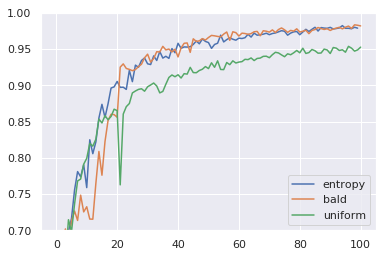

In [177]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()
# plt.plot(entropy_perf_hist, label="entropy")
# plt.plot(bald_perf_hist, label="bald")
# plt.plot(uniform_perf_hist, label="uniform")
# plt.ylim([0.7,1])
# plt.legend()